# Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pandas as pd

In [3]:
import fastai
from fastai import *
from fastai.vision.all import *
from fastai.metrics import F1Score, accuracy

In [4]:
fastai.__version__

'2.1.5'

In [5]:
gs_path = Path('../data/GS')
gs_path.absolute()
assert gs_path.exists()

In [34]:
model_fn = 'resnet-50.fai'

# Prepare Data

In [139]:
rows = []
for ds_path in gs_path.iterdir():
    ds_name = ds_path.name
    for t in ['on', 'off']:
        for image_path in (ds_path / t).iterdir():
            ion = image_path.name.split('.')[0]
            rows.append([ds_name, t, ion])
df = (pd.DataFrame(rows, columns=['dsName', 'type', 'ion'])
        .sort_values(by=['dsName', 'type', 'ion'])
        .reset_index(drop=True))

In [140]:
# Number of datasets available
len(list(gs_path.iterdir()))

87

In [141]:
row_list = []
for ds_path in gs_path.iterdir():
    for cl in ['on', 'off']:
        for p in (ds_path / cl).iterdir():
            row_list.append([str(p), ds_path.name, cl])

image_df = pd.DataFrame(row_list, columns=['name', 'group', 'label'])
image_df.shape

(23238, 3)

In [142]:
image_df.head()

,name,group,label
0,../data/GS/ICL__LNTO30_16_1/on/C39H78NO8P-H.png,ICL__LNTO30_16_1,on
1,../data/GS/ICL__LNTO30_16_1/on/C18H36O2-H.png,ICL__LNTO30_16_1,on
2,../data/GS/ICL__LNTO30_16_1/on/C54H101NO13-H.png,ICL__LNTO30_16_1,on
3,../data/GS/ICL__LNTO30_16_1/on/C42H81NO3-H.png,ICL__LNTO30_16_1,on
4,../data/GS/ICL__LNTO30_16_1/on/C22H36O2-H.png,ICL__LNTO30_16_1,on


In [143]:
all_groups = list(image_df.group.unique())
print(len(all_groups))

87


In [144]:
pd.value_counts(image_df.label)

on     13329
off     9909
Name: label, dtype: int64

# Train and Save Model

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
_, test_groups = train_test_split(image_df.group.unique(), test_size=0.2)
image_df['valid'] = image_df.group.isin(test_groups)

In [27]:
dls = ImageDataLoaders.from_df(
    image_df, label_col="label", valid_col="valid",
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(flip_vert=True, max_rotate=15)
).cuda()

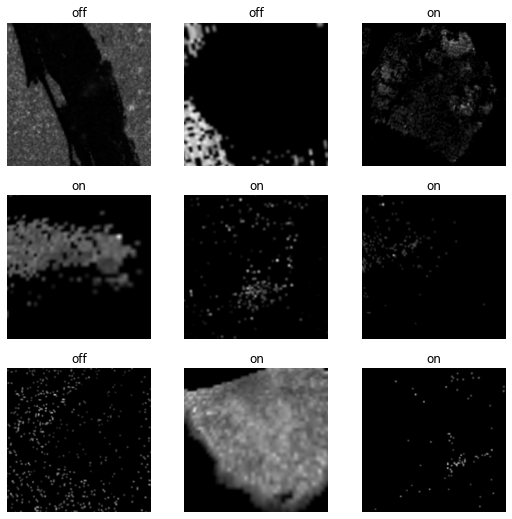

In [37]:
dls.show_batch()

In [32]:
learn = cnn_learner(dls, resnet50, metrics=[accuracy, F1Score()])

In [33]:
lr = 3e-3
learn.fit_one_cycle(5, slice(lr), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.204395,0.321503,0.896231,0.889661,06:19
1,0.144168,0.261988,0.903266,0.892966,06:17
2,0.120429,0.269546,0.909548,0.897494,06:17
3,0.090333,0.261854,0.906784,0.895286,06:17
4,0.083662,0.218396,0.918090,0.909595,06:17


In [35]:
learn.unfreeze()
div = 10
learn.fit_one_cycle(5, slice(1e-5, lr/div), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.096273,0.227610,0.913568,0.907824,08:04
1,0.076787,0.224787,0.912060,0.904684,08:02
2,0.070418,0.220021,0.921106,0.914114,08:02
3,0.056158,0.176292,0.929648,0.923204,08:02
4,0.059495,0.188131,0.925879,0.919509,08:02


In [36]:
learn.save(model_fn)

Path('models/resnet-50.fai.pth')

# Test Inference

In [90]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [91]:
learn.load(model_fn)

In [145]:
# test_df = image_df[image_df.valid]
# test_dl = dls.test_dl(test_df.name, item_tfms=Resize(224))
# test_dl.show_batch()

In [133]:
pred_probs, _ = learn.get_preds(ds_idx=1)
pred_probs.shape

In [146]:
learn.dls.vocab

['off', 'on']

In [135]:
preds = pred_probs[:, 0] > 0.5

In [136]:
y = (test_df.label == 'off').astype(int).values
y.shape

(3980,)

In [137]:
accuracy_score(y_true=y, y_pred=preds), f1_score(y_true=y, y_pred=preds)

(0.9258793969849246, 0.9313154831199069)

In [138]:
confusion_matrix(y, preds)

array([[1685,  176],
       [ 119, 2000]])